# Task 1 : Set up colab gpu runtime environment

In [112]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3kmpws_q
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3kmpws_q
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [113]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


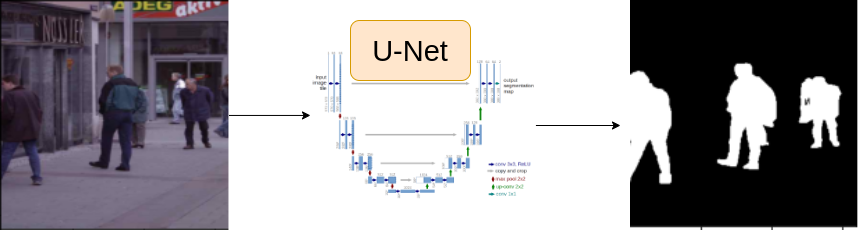

# Some Common Imports

In [114]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [145]:
import torch
torch.cuda.empty_cache() 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [156]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 5

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [117]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [118]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0


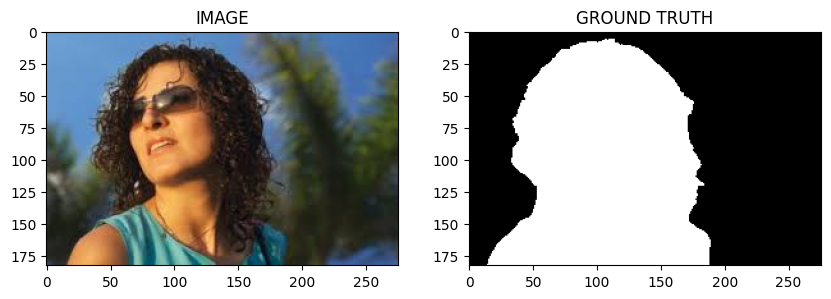

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [120]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [121]:
import albumentations as A

In [122]:
def get_train_augs():
  return A.Compose([ 
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [123]:
from torch.utils.data import Dataset

In [124]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def  __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (height,width,channel)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']
    # (h,w, c) -> (c,w,h)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))/255.0

    return image,mask



In [125]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [126]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


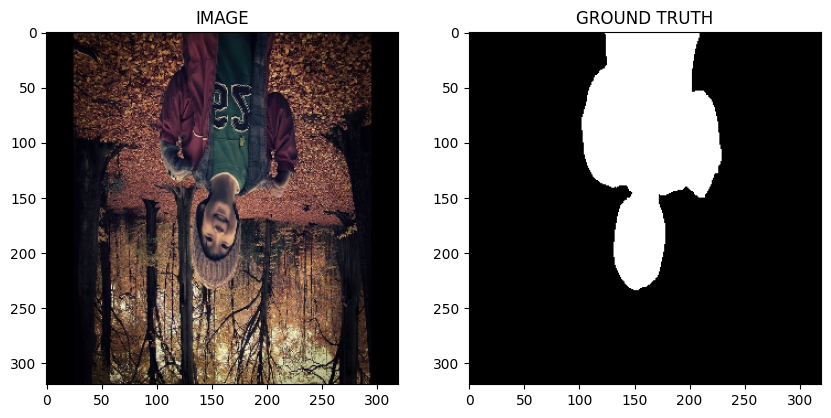

In [127]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [128]:
from torch.utils.data import DataLoader

In [129]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [130]:
print(f'Total no. batches in trainloader: {len(trainloader)}')
print(f'Total no. batches in validloader: {len(validloader)}')

Total no. batches in trainloader: 15
Total no. batches in validloader: 4


In [131]:
for image,mask in trainloader:
  break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [132]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [133]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2 
    
    return logits




In [134]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [135]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    
    logits,loss = model(images,masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)



In [165]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [162]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [163]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 7            |        cudaMalloc retries: 8         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 131873 KiB |  14852 MiB |   1495 GiB |   1495 GiB |\n|       from large pool |  75628 KiB |  14783 MiB |   1491 GiB |   1491 GiB |\n|       from small pool |  56245 KiB |    109 MiB |      3 GiB |      3 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 131873 KiB |  14852 MiB |   1495 GiB |   1495 GiB |\n|       from large pool |  75628 KiB |  14783 MiB |

In [166]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')

    best_valid_loss = valid_loss
  
  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.25915725231170655 Valid_loss: 0.27010565996170044


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 2 Train_loss: 0.23079797426859539 Valid_loss: 0.28219305351376534


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 3 Train_loss: 0.21718979974587757 Valid_loss: 0.2933051064610481


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED-MODEL
Epoch: 4 Train_loss: 0.18402264515558878 Valid_loss: 0.23305431008338928


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


SAVED-MODEL
Epoch: 5 Train_loss: 0.21710567971070607 Valid_loss: 0.20240361243486404


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch: 6 Train_loss: 0.16283109287420908 Valid_loss: 0.20529191195964813


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 7 Train_loss: 0.20192813475926716 Valid_loss: 0.27403486147522926


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 8 Train_loss: 0.19473368922869363 Valid_loss: 0.22232908755540848


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 9 Train_loss: 0.18728710959355035 Valid_loss: 0.27144791930913925


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 10 Train_loss: 0.18503154416879017 Valid_loss: 0.23873039707541466


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Epoch: 11 Train_loss: 0.18541906774044037 Valid_loss: 0.2153187431395054


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 12 Train_loss: 0.1552836552262306 Valid_loss: 0.21386723965406418


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch: 13 Train_loss: 0.13296064088741938 Valid_loss: 0.21978358179330826


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAVED-MODEL
Epoch: 14 Train_loss: 0.11854556451241176 Valid_loss: 0.17938053607940674


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


SAVED-MODEL
Epoch: 15 Train_loss: 0.1158687894543012 Valid_loss: 0.14268945716321468


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Epoch: 16 Train_loss: 0.16813360005617142 Valid_loss: 0.33245428651571274


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 17 Train_loss: 0.18897711634635925 Valid_loss: 0.22826330363750458


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 18 Train_loss: 0.16685941219329833 Valid_loss: 0.1814572624862194


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch: 19 Train_loss: 0.14040678044160207 Valid_loss: 0.22806990146636963


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch: 20 Train_loss: 0.12535267571608225 Valid_loss: 0.18930313736200333


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Epoch: 21 Train_loss: 0.10639163007338842 Valid_loss: 0.23842165246605873


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 22 Train_loss: 0.10640687942504883 Valid_loss: 0.2355610653758049


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 23 Train_loss: 0.10281833360592524 Valid_loss: 0.22093377262353897


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 24 Train_loss: 0.10376195708910624 Valid_loss: 0.19950547814369202


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

Epoch: 25 Train_loss: 0.10549961477518081 Valid_loss: 0.17724844440817833


# Task 9 : Inference

In [170]:
idx =2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask>0.5)*1.0




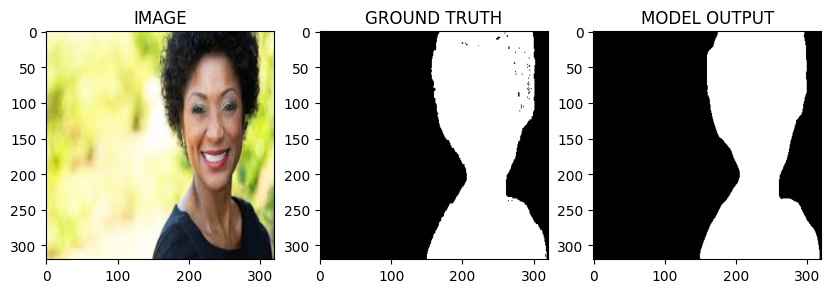

In [171]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0) )

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya